In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# FASTER R CNN - Bus/Truck Object Detection

## kaggle data download

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms

import utils
import os
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import matplotlib.pyplot as plt

from ipywidgets import interact

In [3]:
!pip install kaggle --upgrade

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seonyong","key":"15cdbf608ae7dcc43e31d8ac3e790795"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!mkdir data/
%cd data

/content/data


In [7]:
!kaggle datasets download -d sixhky/open-images-bus-trucks

100% 365M/367M [00:04<00:00, 63.7MB/s]
100% 367M/367M [00:05<00:00, 76.8MB/s]


In [8]:
!unzip -qq '/content/data/open-images-bus-trucks.zip'

## data 전처리

In [9]:
data_dir  = '/content/data/images'

In [10]:
# 데이터 전체 수
data_len = os.listdir(data_dir + '/images')
len(data_len)

15225

In [11]:
df = pd.read_csv('/content/data/df.csv')
df = df.loc[:, ['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']]
df.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,0000599864fd15b3,Bus,0.343750,0.908750,0.156162,0.650047
1,00006bdb1eb5cd74,Truck,0.276667,0.697500,0.141604,0.437343
2,00006bdb1eb5cd74,Truck,0.702500,0.999167,0.204261,0.409774
3,00010bf498b64bab,Bus,0.156250,0.371250,0.269188,0.705228
4,00013f14dd4e168f,Bus,0.287500,0.999375,0.194184,0.999062


- 데이터셋 나누기

In [12]:
# 데이터셋 비율 - 8:1:1
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(data_len) * split_ratio[0])
val_len = int(len(data_len) * split_ratio[1])
test_len = len(data_len) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

12180, 1522, 1523


In [13]:
# 데이터를 랜덤으로 섞고 길이에 따라서 데이터 나누기
data_list = (os.listdir(data_dir+'/images'))
random.shuffle(data_list)

train_img, val_img, test_img = [], [], []

for i in range(len(data_list)):
    if 0 <= i < train_len:
        train_img.append(data_list[i])
    elif train_len <= i < train_len + val_len:
        val_img.append(data_list[i])
    elif train_len + val_len <= i:
        test_img.append(data_list[i])

print('{}, {}, {}'.format(len(train_img), len(val_img), len(test_img)))

12180, 1522, 1523


In [14]:
!mkdir 'train' 'val' 'test'

In [ ]:
# 8:1:1 비율로 각각의 폴더 안에 데이터 나누어 넣기
to_file_path = '/content/data/'
from_file_path = '/content/data/images/images/'

for idx, file_name in enumerate(os.listdir(from_file_path)):
    if 0 <= idx < train_len:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'train/' + file_name)
    elif train_len <= idx < train_len + val_len:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'val/' + file_name)
    elif train_len +  val_len <= idx:
        shutil.copyfile(from_file_path + file_name, to_file_path + 'test/' + file_name)

print('{}, {}, {}'.format(len(os.listdir(to_file_path+'train')), len(os.listdir(to_file_path+'val')), len(os.listdir(to_file_path+'test'))))

In [16]:
print('{}, {}, {}'.format(len(os.listdir(to_file_path+'train')), len(os.listdir(to_file_path+'val')), len(os.listdir(to_file_path+'test'))))

12180, 1522, 1523


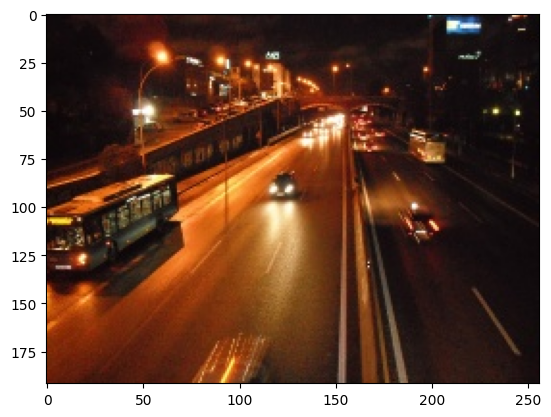

In [51]:
data_dir = '/content/data'

index = 205
file_name = os.listdir(data_dir + '/train')[index]
image = cv2.imread(os.path.join(data_dir, 'train', file_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [64]:
image_id = file_name.split('.')[0]
image_id

'03458cffc59d58fa'

In [65]:
# 바운딩 box는 하나가 아닐 수도 있다
meta_data = df[df['ImageID'] == image_id]
meta_data

,ImageID,LabelName,XMin,YMax,XMax,YMin
1084,03458cffc59d58fa,Bus,0.000000,0.695833,0.271875,0.426667
1085,03458cffc59d58fa,Bus,0.731875,0.402500,0.817500,0.305000


In [66]:
label = meta_data['LabelName'].values
label

array(['Bus', 'Bus'], dtype=object)

In [70]:
# Normalize -> 원본 크기로 변환해야 할 필요가 있다.
boxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
print(boxes, type(boxes[0]))

[[0.       0.271875 0.426667 0.695833]
 [0.731875 0.8175   0.305    0.4025  ]] <class 'numpy.ndarray'>


In [71]:
CLASS_NAME_TO_ID = {'Bus':0, 'Truck':1}
CLASS_NAME_TO_ID

{'Bus': 0, 'Truck': 1}

In [72]:
class_ids = [CLASS_NAME_TO_ID[id] for id in label]
class_ids

[0, 0]

In [73]:
img_H, img_W, _ = image.shape

unnorm_bboxes = boxes.copy()
unnorm_bboxes[:, [1,2]] = unnorm_bboxes[:, [2,1]]
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)
unnorm_bboxes[:, [0,2]] *= img_W
unnorm_bboxes[:, [1,3]] *= img_H

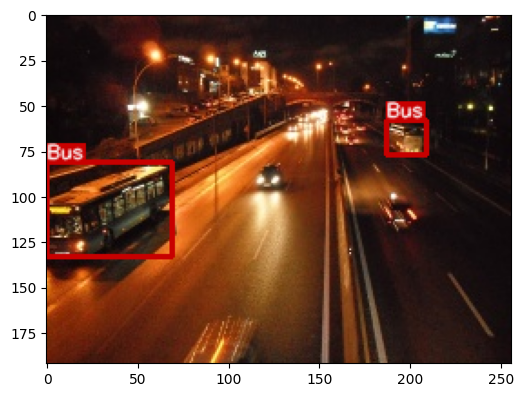

In [79]:
canvas = utils.visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.show()

{0: 'Bus', 1: 'Truck'}